# Import Libraries

In [1]:
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import csv
from datetime import datetime

# Utilities

In [2]:
def plot_series(x, y, format="-", start=0, end=None, title=None, xlabel=None, ylabel=None, legend=None):
    plt.figure(figsize=(12, 8))  # Increase figure size
    if type(y) is tuple:
        for y_curr in y:
            plt.plot(x[start:end], y_curr[start:end], format)
    else:
        plt.plot(x[start:end], y[start:end], format)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    if legend:
        plt.legend(legend)
    plt.title(title)
    plt.grid(True)
    plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
    plt.show()

# Load Dataset

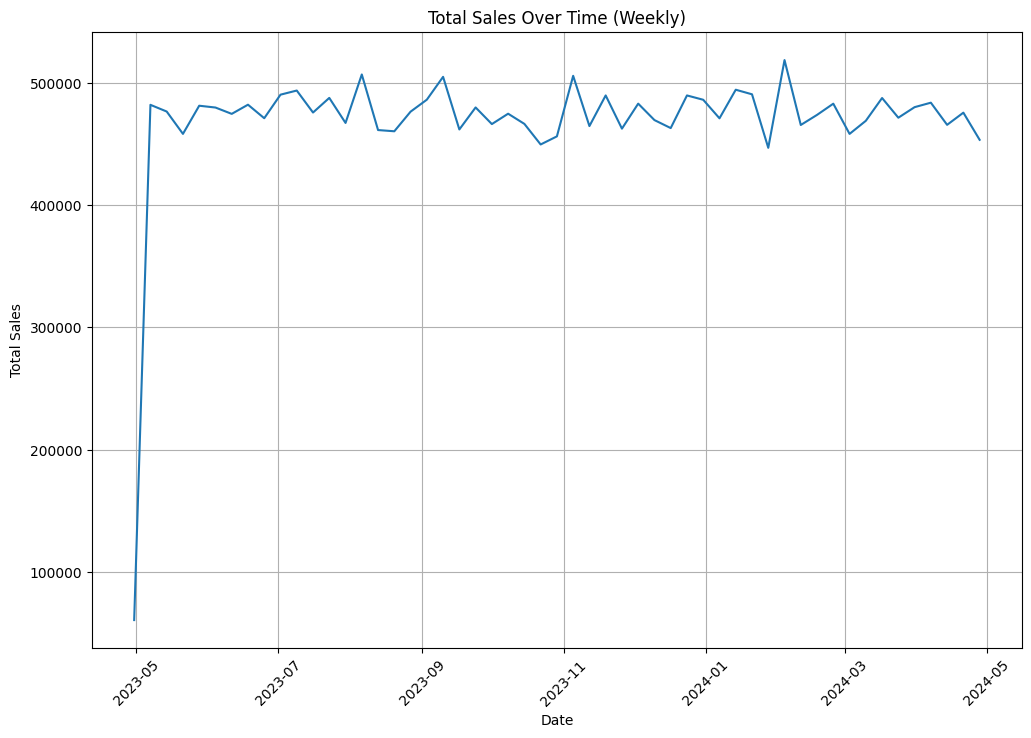

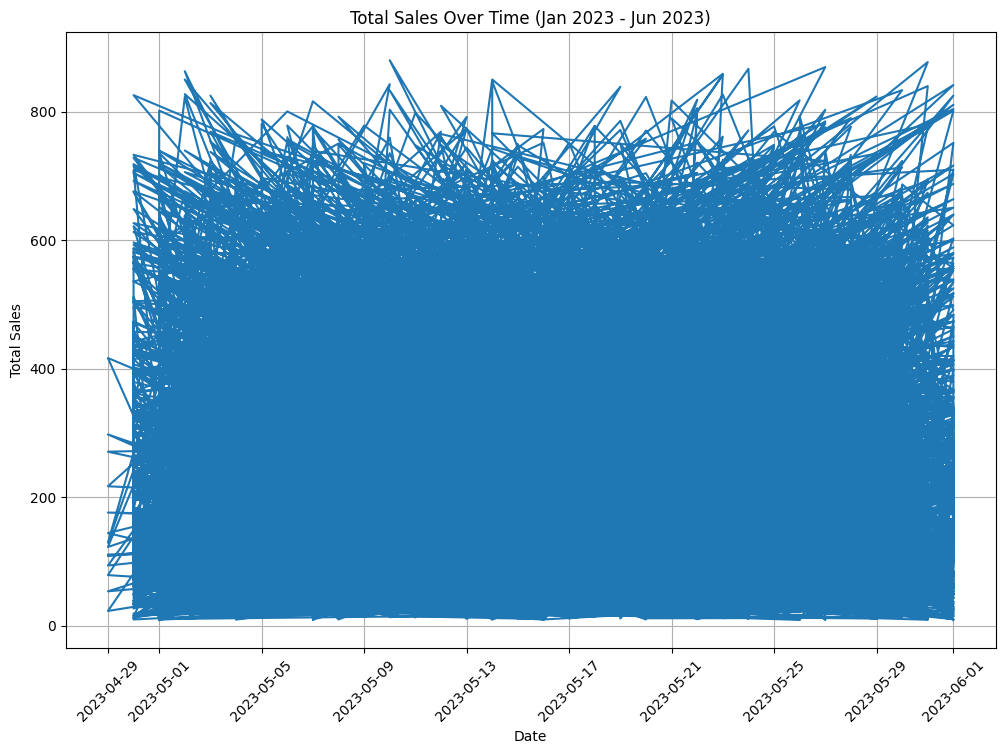

In [3]:
# Load Dataset
file_path = "Dataset/Transformed_Retail_Transaction_Dataset.csv"
df = pd.read_csv(file_path, parse_dates=['Date'])

# Extracting dates and sales
time = np.array(df['Date'])
series = np.array(df['Total Sales'])

# Downsample the data for visualization (weekly)
downsampled_df = df.resample('W', on='Date').sum()

# Plot the downsampled data
plot_series(downsampled_df.index, downsampled_df['Total Sales'], xlabel='Date', ylabel='Total Sales', title='Total Sales Over Time (Weekly)')

# Define a shorter period for plotting (optional)
start_date = '2023-01-01'
end_date = '2023-06-01'
mask = (df['Date'] >= start_date) & (df['Date'] <= end_date)
filtered_df = df.loc[mask]

# Plot the filtered data
plot_series(filtered_df['Date'], filtered_df['Total Sales'], xlabel='Date', ylabel='Total Sales', title='Total Sales Over Time (Jan 2023 - Jun 2023)')

# Split Dataset

In [4]:
ROW_COUNT = len(series)
SPLIT_TIME = int(0.7 * ROW_COUNT)

time_train = time[:SPLIT_TIME]
x_train = series[:SPLIT_TIME]

time_valid = time[SPLIT_TIME:]
x_valid = series[SPLIT_TIME:]

# Features and Labels

In [5]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
    dataset = tf.data.Dataset.from_tensor_slices(series)
    dataset = dataset.window(window_size + 1, shift=1, drop_remainder=True)
    dataset = dataset.flat_map(lambda window: window.batch(window_size + 1))
    dataset = dataset.map(lambda window: (window[:-1], window[-1]))
    dataset = dataset.shuffle(shuffle_buffer)
    dataset = dataset.batch(batch_size).prefetch(1)
    return dataset

WINDOW_SIZE = 7
BATCH_SIZE = 32
SHUFFLE_BUFFER_SIZE = 100

train_set = windowed_dataset(x_train, WINDOW_SIZE, BATCH_SIZE, SHUFFLE_BUFFER_SIZE)

# Build The Model

In [6]:
from tensorflow.keras.layers import Conv1D, Dense, LSTM
from tensorflow.keras.regularizers import l2

model = tf.keras.models.Sequential([
    Conv1D(
        filters=16,
        kernel_size=3,
        activation="relu",
        padding='causal',
        input_shape=[WINDOW_SIZE, 1],
        kernel_regularizer=l2(0.001)
    ),
    LSTM(64, return_sequences=True, activation='relu'),
    LSTM(32, return_sequences=False, activation='relu'),
    Dense(16, activation='relu'),
    Dense(8, activation='relu'),
    Dense(1)
])

# Print the model summary
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 7, 16)             64        
                                                                 
 lstm (LSTM)                 (None, 7, 64)             20736     
                                                                 
 lstm_1 (LSTM)               (None, 32)                12416     
                                                                 
 dense (Dense)               (None, 16)                528       
                                                                 
 dense_1 (Dense)             (None, 8)                 136       
                                                                 
 dense_2 (Dense)             (None, 1)                 9         
                                                                 
Total params: 33889 (132.38 KB)
Trainable params: 33889 

# Train the Model

In [7]:
tf.keras.backend.clear_session()
model.compile(loss=tf.keras.losses.Huber(), optimizer='adam', metrics=["mae"])
history = model.fit(train_set, epochs=30, verbose=1)

Epoch 1/30
2188/2188 [==============================] - 73s 29ms/step - loss: 149.8199 - mae: 150.3177
Epoch 2/30
2188/2188 [==============================] - 68s 31ms/step - loss: 147.7930 - mae: 148.2909
Epoch 3/30
2188/2188 [==============================] - 66s 30ms/step - loss: 147.2959 - mae: 147.7939
Epoch 4/30
2188/2188 [==============================] - 63s 29ms/step - loss: 147.1170 - mae: 147.6152
Epoch 5/30
2188/2188 [==============================] - 64s 29ms/step - loss: 147.0001 - mae: 147.4981
Epoch 6/30
2188/2188 [==============================] - 64s 29ms/step - loss: 146.8807 - mae: 147.3788
Epoch 7/30
2188/2188 [==============================] - 64s 29ms/step - loss: 146.7973 - mae: 147.2956
Epoch 8/30
2188/2188 [==============================] - 64s 29ms/step - loss: 146.8285 - mae: 147.3267
Epoch 9/30
2188/2188 [==============================] - 63s 29ms/step - loss: 146.7767 - mae: 147.2750
Epoch 10/30
2188/2188 [==============================] - 63s 29ms/step - 

# Visualize Training Results

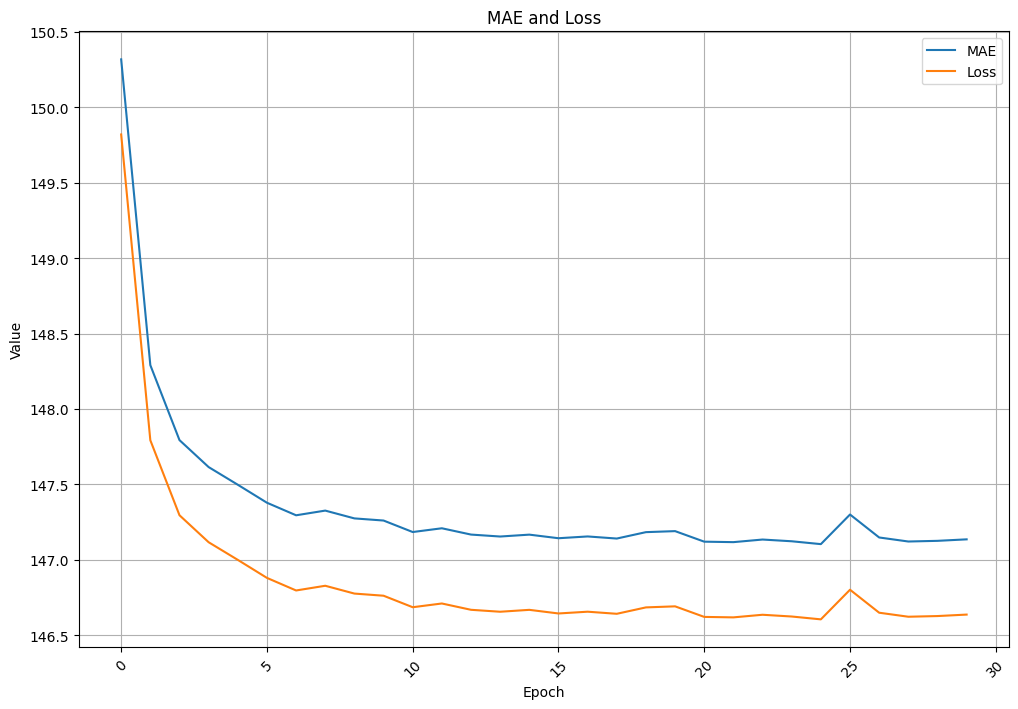

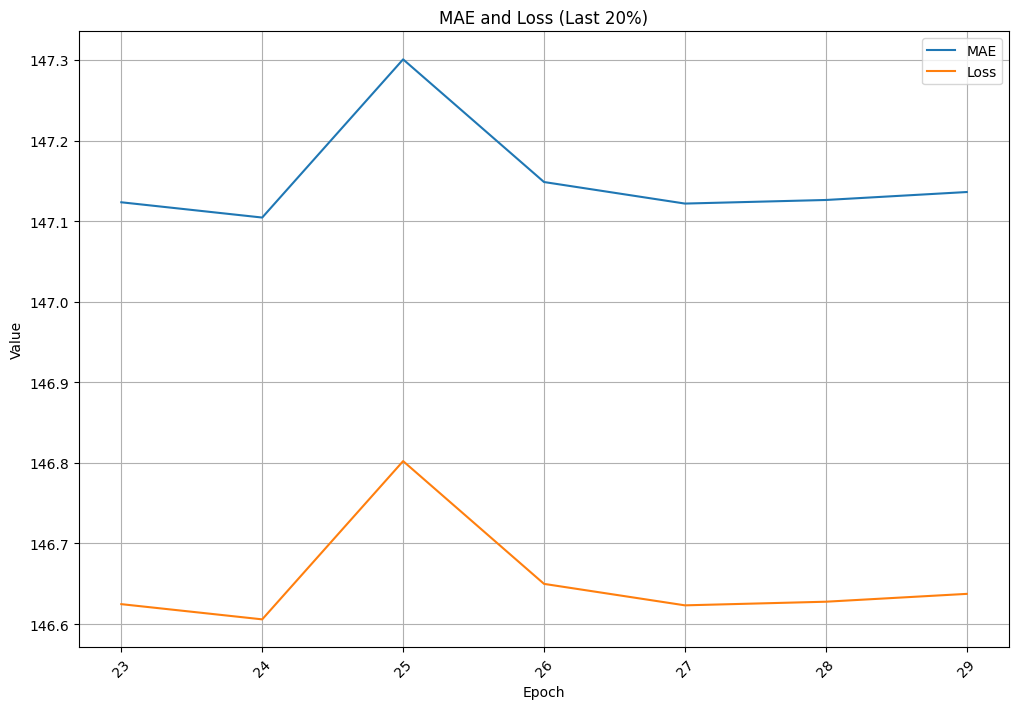

In [8]:
mae = history.history['mae']
loss = history.history['loss']
epochs = range(len(loss))

plot_series(
    x=epochs,
    y=(mae, loss),
    title='MAE and Loss',
    xlabel='Epoch',
    ylabel='Value',
    legend=['MAE', 'Loss']
)

# Only plot the last 20% of the epochs
zoom_split = int(epochs[-1] * 0.8)
epochs_zoom = epochs[zoom_split:]
mae_zoom = mae[zoom_split:]
loss_zoom = loss[zoom_split:]

plot_series(
    x=epochs_zoom,
    y=(mae_zoom, loss_zoom),
    title='MAE and Loss (Last 20%)',
    xlabel='Epoch',
    ylabel='Value',
    legend=['MAE', 'Loss']
)

# Model Prediction

938/938 [==============================] - 7s 7ms/step


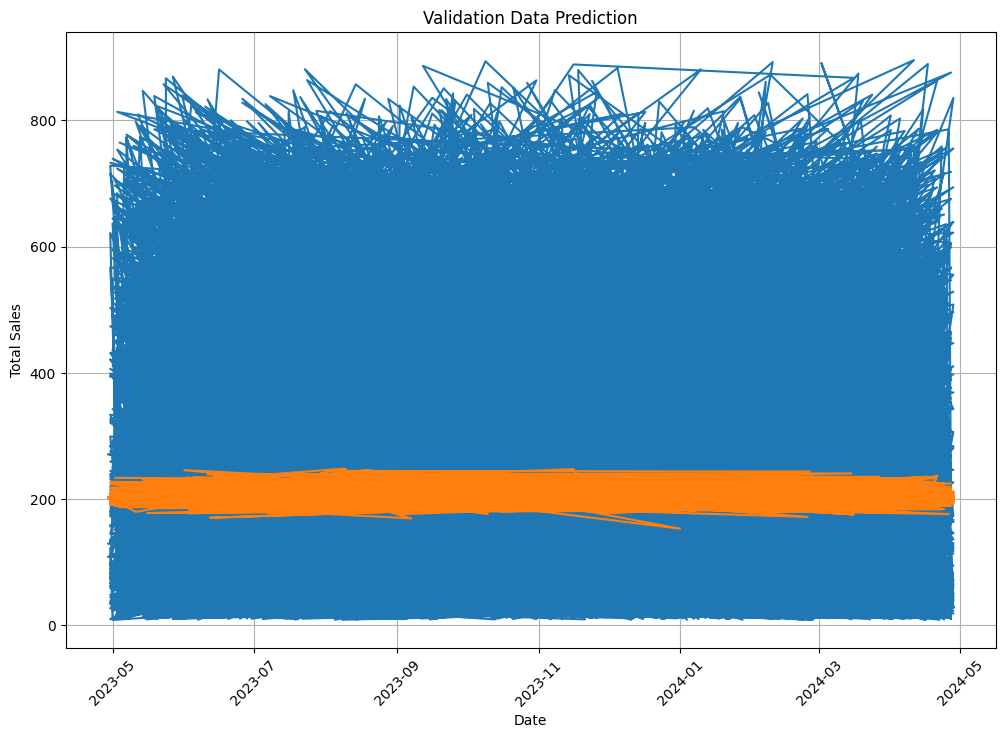

3125/3125 [==============================] - 20s 6ms/step


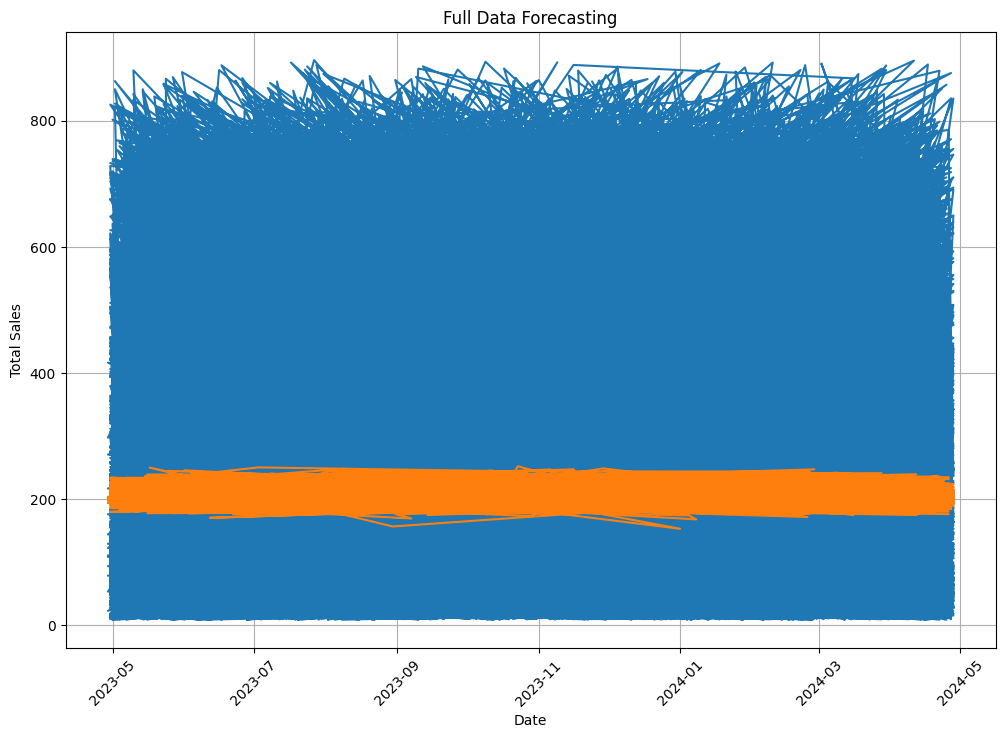

In [9]:
def model_forecast(model, series, window_size, batch_size):
    dataset = tf.data.Dataset.from_tensor_slices(series)
    dataset = dataset.window(window_size, shift=1, drop_remainder=True)
    dataset = dataset.flat_map(lambda w: w.batch(window_size))
    dataset = dataset.batch(batch_size).prefetch(1)
    forecast = model.predict(dataset)
    return forecast

forecast_series = series[SPLIT_TIME - WINDOW_SIZE: -1]
forecast = model_forecast(model, forecast_series, WINDOW_SIZE, BATCH_SIZE)
results = forecast.squeeze()

# Plot the validation data and predictions
plot_series(time_valid, (x_valid, results), xlabel='Date', ylabel='Total Sales', title='Validation Data Prediction')

# Plot the full time series and predictions
full_forecast_series = series[:-1]
full_forecast = model_forecast(model, full_forecast_series, WINDOW_SIZE, BATCH_SIZE)
full_results = full_forecast.squeeze()

plot_series(time[WINDOW_SIZE:], (series[WINDOW_SIZE:], full_results), xlabel='Date', ylabel='Total Sales', title='Full Data Forecasting')

# Save the Model

In [11]:
model.save("ModelResult/retail_transaction.h5")